# Retail Business Analysis
---

This analysis provides actionable insights to improve sales performance based on comprehensive retail transaction data analysis. 


## 1. Objectives & Research Framework

### 1.1 Problem Statement
The company requires insights to improve sales performance. To do that, understanding product characteristic, customer behavior patterns, and market trend is key to identify growth opportunities in their business operation.

### 1.2 Business Questions
1. **Revenue Optimization:** What are the key drivers of sales performance?
2. **Product Strategy:** Which products contribute most to revenue and should be prioritized?
3. **Customer Insights:** What are the purchasing patterns and behaviors?
4. **Seasonality:** How do sales vary over time and what are the seasonal trends?
5. **Geographic Performance:** Which markets show the strongest performance?
6. **Outlier Analysis:** Any insights on unexpected behavior?

### 1.3 Approach
- **Data Quality Check:** Data loading and preprocessing to avoid noise and sanitize analysis
- **Data Analysis:** Using the defined business question, identify key metric and analyze results
- **Insight Visualization:** Visualize the findings into executive digestable format
- **Insights Summary:** Summarize the opportunity as recommendation for the stakeholders

## 2. Data Quality Check


In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Environment Setup Complete")

Environment Setup Complete


In [16]:
# Load the dataset
df = pd.read_csv('datasets/retail_transaction_data.csv')


print("DATASET OVERVIEW")
print("-" * 50)

# Basic dataset information
print(f"Dataset Shape: {df.shape[0]:,} transactions with {df.shape[1]} features")
print(f"Data Period: {df['order_date'].min()} to {df['order_date'].max()}")

# Display sample data
print("\nSample Data:")
df.head()


DATASET OVERVIEW
--------------------------------------------------
Dataset Shape: 1,067,371 transactions with 8 features
Data Period: 2009-12-01 07:45:00 to 2011-12-09 12:50:00

Sample Data:


,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [17]:
# Data Quality Assessment
print("DATA QUALITY CHECK")
print("-" * 50)

# Descriptive statistics of the dataset
display(df.describe().round(2))

# Check data types and missing values
quality_summary = pd.DataFrame({
    # 'Column': df.columns,
    'Data_Type': df.dtypes,
    'Missing_Values': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Unique_Values': [df[col].nunique() for col in df.columns]
})

display(quality_summary)

# Check for anomalies
print(f"Negative quantities: {(df['quantity'] < 0).sum():,}")
print(f"Zero/negative prices: {(df['unit_price'] <= 0).sum():,}")
print(f"Missing customer IDs: {df['customer_id'].isnull().sum():,}")


DATA QUALITY CHECK
--------------------------------------------------


,quantity,unit_price,customer_id
count,1067371.00,1067371.00,824364.00
mean,9.94,4.65,15324.64
std,172.71,123.55,1697.46
min,-80995.00,-53594.36,12346.00
25%,1.00,1.25,13975.00
50%,3.00,2.10,15255.00
75%,10.00,4.15,16797.00
max,80995.00,38970.00,18287.00


,Data_Type,Missing_Values,Missing_Percentage,Unique_Values
order_id,object,0,0.00,53628
product_id,object,0,0.00,5305
product_description,object,4382,0.41,5698
quantity,int64,0,0.00,1057
order_date,object,0,0.00,47635
unit_price,float64,0,0.00,2807
customer_id,float64,243007,22.77,5942
country,object,0,0.00,43


Negative quantities: 22,950
Zero/negative prices: 6,207
Missing customer IDs: 243,007


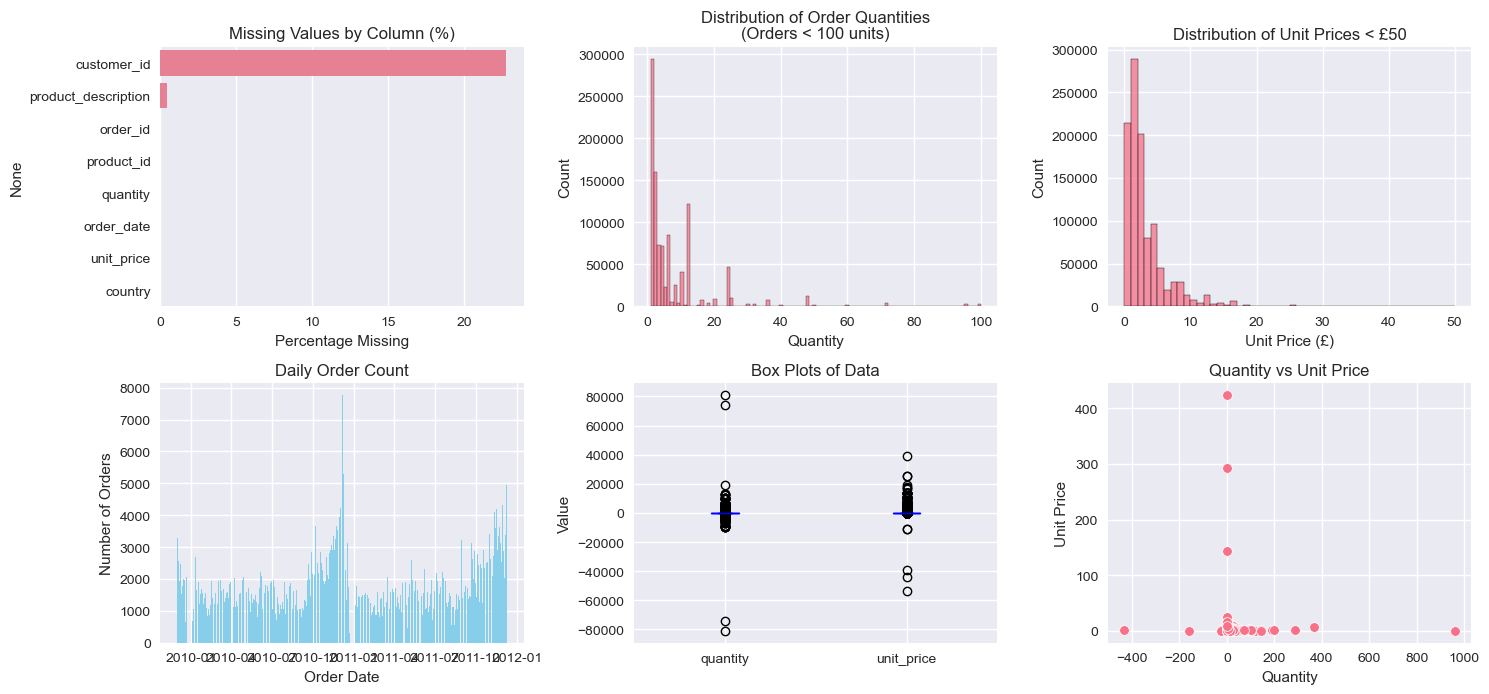


ADDITIONAL QUALITY METRICS
--------------------------------------------------
Price Range: £-53594.36 to £38970.00
Quantity Range: -80995 to 80995 units
Number of orders with quantity > 100: 10,561
Number of products priced > £50: 2,557


In [18]:
# Initial Data quality check visualization

def plot_data_quality(df):
    # Create a figure with subplots for data quality visualization
    plt.figure(figsize=(15, 10))

    # 1. Missing Values Bar Plot
    plt.subplot(3, 3, 1)
    missing_data = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    sns.barplot(x=missing_data.values, y=missing_data.index)
    plt.title('Missing Values by Column (%)')
    plt.xlabel('Percentage Missing')

    # 2. Distribution of Quantities
    plt.subplot(3, 3, 2)
    sns.histplot(data=df[df['quantity'].between(0, 100)], x='quantity', bins=100)
    plt.title('Distribution of Order Quantities\n(Orders < 100 units)')
    plt.xlabel('Quantity')

    # 3. Distribution of Unit Prices
    plt.subplot(3, 3, 3)
    sns.histplot(data=df[df['unit_price'].between(0, 50)], x='unit_price', bins=50 )
    plt.title('Distribution of Unit Prices < £50')
    plt.xlabel('Unit Price (£)')

    # 4. Daily Order Count Time Series
    plt.subplot(3, 3, 4)
    df_time = df.copy()
    df_time['order_date'] = pd.to_datetime(df_time['order_date'])
    daily_orders = df_time.set_index('order_date').resample('D').size()
    plt.bar(daily_orders.index, daily_orders.values, width=1.0, color='skyblue')
    plt.title('Daily Order Count')
    plt.xlabel('Order Date')
    plt.ylabel('Number of Orders')

    # 5. Box plot of Normalized Data
    plt.subplot(3, 3, 5)
    df.boxplot(column=['quantity', 'unit_price'], color='blue')
    plt.title('Box Plots of Data')
    plt.ylabel('Value')

    # Quantity vs Unit Price scatter
    plt.subplot(3, 3, 6)
    sns.scatterplot(data=df.sample(1000), x='quantity', y='unit_price')
    plt.title('Quantity vs Unit Price')
    plt.xlabel('Quantity')
    plt.ylabel('Unit Price')
    
    plt.tight_layout()
    plt.show()

    # Print additional quality metrics
    print("\nADDITIONAL QUALITY METRICS")
    print("-" * 50)
    print(f"Price Range: £{df['unit_price'].min():.2f} to £{df['unit_price'].max():.2f}")
    print(f"Quantity Range: {df['quantity'].min()} to {df['quantity'].max()} units")
    print(f"Number of orders with quantity > 100: {len(df[df['quantity'] > 100]):,}")
    print(f"Number of products priced > £50: {len(df[df['unit_price'] > 50]):,}")

plot_data_quality(df)

Based on the descriptive statistics and initial exploratory of the dataset, we found that:

1. Invalid data logic like negative quantities and zero prices is present in the dataset.
2. There are missing values in several columns, including customer_id and product_id.
3. The distribution of order quantities is highly skewed, with a small number of orders containing large quantities.
4. Most products have a unit price below £50, but a few outliers are priced significantly higher.
5. Invalid product IDs are found, which do not match the expected format.
6. order_ids starting with "C" is a refund transaction so we need to take out both.
7. Some product description shows non standardize value with questionable data quality, need to take out

So the data cleaning and preprocessing steps that we have to do:

1. Remove invalid transactions with negative quantities, zero prices, or missing customer IDs.
2. Remove missing values in critical columns like customer_id and product_id.
4. Remove product IDs that do not match the expected format.
5. Separate outliers transaction into different table, for different analysis. (anomaly exploration)

In [19]:
# Data Preprocessing and Feature Engineering
print("DATA PREPROCESSING & FEATURE ENGINEERING")
print("-" * 50)

df_clean = df.copy()

# Convert order_date to datetime
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'])

# Create key business metrics
df_clean['total_amount'] = df_clean['quantity'] * df_clean['unit_price']
df_clean['year'] = df_clean['order_date'].dt.year
df_clean['month'] = df_clean['order_date'].dt.month
df_clean['quarter'] = df_clean['order_date'].dt.quarter
df_clean['day_of_week'] = df_clean['order_date'].dt.day_name()
df_clean['month_year'] = df_clean['order_date'].dt.to_period('M')

# Clean data: Remove negative quantities and zero prices (likely returns/errors)
df_clean = df_clean[(df_clean['quantity'] > 0) & (df_clean['unit_price'] > 0) & (df_clean['customer_id'].notna())].copy()
invalid_data_logic_trx = df[(df['quantity'] <= 0) | (df['unit_price'] <= 0) | (df['customer_id'].isna())].shape[0]

# Clean data only keep those with product_id containing 5 numbers at start
df_clean = df_clean[df_clean['product_id'].str.match(r'^\d{5}')]
invalid_product_trx = len(df[~df['product_id'].str.match(r'^\d{5}')])

# Take out product with less than 4 uppercase letters
invalid_product_description_trx = df_clean[df_clean['product_description'].str.count(r'[A-Z]') < 4].shape[0]
df_clean = df_clean[df_clean['product_description'].str.count(r'[A-Z]') >= 4]

# Clean refund data. (data starting with C and order_id with the same order_id without C)
# List all of the refund transaction
refund_transactions = df[df['order_id'].str.startswith('C')]
# take the product_id and customer_id from the refund transaction
refund_products = refund_transactions[['product_id', 'customer_id']]
# filter the same product id and customer_id
df_clean = df_clean[~df_clean[['product_id', 'customer_id']].apply(tuple, 1).isin(refund_products.apply(tuple, 1))]


print(f"Added features: {len(df_clean.columns) - len(df.columns)} {list(set(df_clean.columns) - set(df.columns))}")
print(f"Original dataset: {len(df):,} transactions")
print(f"Number of transactions with invalid product description: {invalid_product_description_trx:,}")
print(f"Number of transactions with invalid data logic: {invalid_data_logic_trx:,}")
print(f"Number of transactions with invalid product_id: {invalid_product_trx:,}")
print(f"Number of refund transactions: {len(refund_transactions):,}")
print(f"Cleaned dataset: {len(df_clean):,} transactions")
print(f"Data removed: {len(df) - len(df_clean):,} transactions ({((len(df) - len(df_clean))/len(df)*100):.1f}%)")

DATA PREPROCESSING & FEATURE ENGINEERING
--------------------------------------------------
Added features: 6 ['quarter', 'month_year', 'total_amount', 'month', 'day_of_week', 'year']
Original dataset: 1,067,371 transactions
Number of transactions with invalid product description: 82
Number of transactions with invalid data logic: 261,822
Number of transactions with invalid product_id: 6,093
Number of refund transactions: 19,494
Cleaned dataset: 757,349 transactions
Data removed: 310,022 transactions (29.0%)


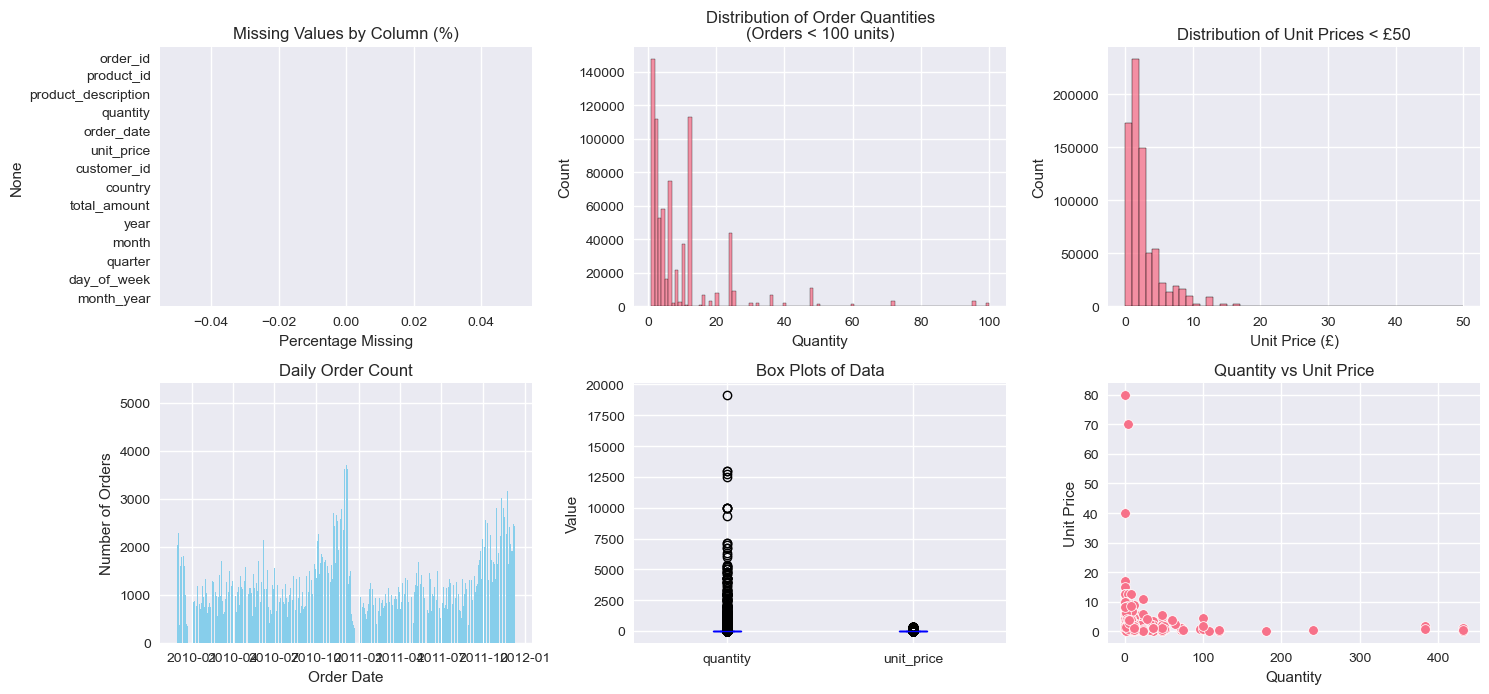


ADDITIONAL QUALITY METRICS
--------------------------------------------------
Price Range: £0.03 to £295.00
Quantity Range: 1 to 19152 units
Number of orders with quantity > 100: 8,325
Number of products priced > £50: 259


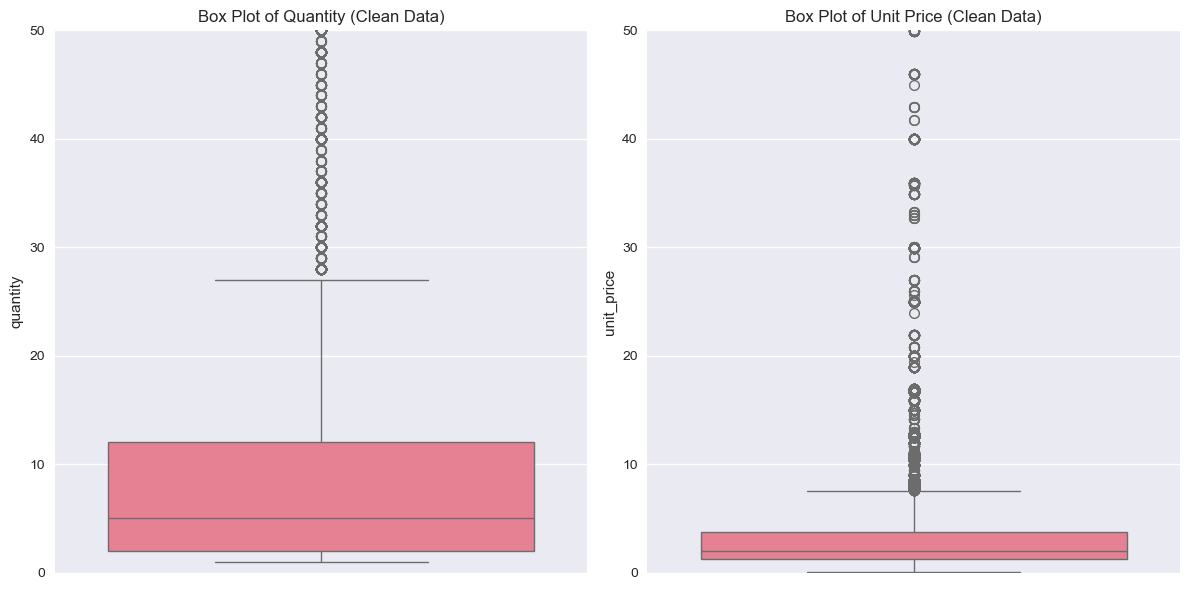

Final clean dataset shape: 757,349 transactions with 14 features


In [20]:
# Final Data quality check visualization
plot_data_quality(df_clean)

# box plot quantity and unit price with y limit = 50
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_clean, y='quantity')
plt.ylim(0, 50)
plt.title('Box Plot of Quantity (Clean Data)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_clean, y='unit_price')
plt.ylim(0, 50)
plt.title('Box Plot of Unit Price (Clean Data)')

plt.tight_layout()
plt.show()

print(f'Final clean dataset shape: {df_clean.shape[0]:,} transactions with {df_clean.shape[1]} features')

The cleaned data makes more reasonable, the quantity and unit price distributions are now more representative of typical pattern (lower unit price correlates with higher quantity sold). The box plot reveal invalid data has been cleaned while we keep retaining reasonable outliers for further analysis.

We need to also create one table for outlier data for further outlier or anomaly analysis. (We might see hidden opportunities behind this data)

In [21]:
# Create normal data without outliers and outlier only data
# Define outlier thresholds using IQR method
Q1_quantity = df_clean['quantity'].quantile(0.25)
Q3_quantity = df_clean['quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity
quantity_lower = Q1_quantity - 1.5 * IQR_quantity
quantity_upper = Q3_quantity + 3 * IQR_quantity

Q1_price = df_clean['unit_price'].quantile(0.25)
Q3_price = df_clean['unit_price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
price_lower = Q1_price - 1.5 * IQR_price
price_upper = Q3_price + 1.5 * IQR_price

# Create outliers only dataset
df_outliers = df_clean[ 
    (df_clean['quantity'] > quantity_upper) 
].copy()

print("Created outlier only datasets")

Created outlier only datasets


In [22]:
# Outlier Analysis: Focus on df_outliers only
print("Outlier Analysis (df_outliers)")
print("-" * 40)

# Show basic info
print(f"Total outlier transactions: {len(df_outliers):,} ({len(df_outliers)/len(df)*100:.2f}%)")

# Price outliers
print(f"Unit price range: £{df_outliers['unit_price'].min():.2f} - £{df_outliers['unit_price'].max():.2f}")

# Quantity outliers
print(f"Quantity range: {df_outliers['quantity'].min()} - {df_outliers['quantity'].max()}")

# Transaction value outliers
print(f"Total amount range: £{df_outliers['total_amount'].min():.2f} - £{df_outliers['total_amount'].max():.2f}")

# Outlier summary by product and customer
outlier_products = df_outliers['product_id'].nunique()
outlier_customers = df_outliers['customer_id'].nunique()
print(f"Percentage Unique products in outliers: {outlier_products/df['product_id'].nunique()*100:.2f}%")
print(f"Percentage Unique customers in outliers: {outlier_customers/df['customer_id'].nunique()*100:.2f}%")

# Show top 5 outlier transactions by value
print("\nTop 5 outlier transactions by value:")
display(df_outliers.sort_values('total_amount', ascending=False).head(5))


Outlier Analysis (df_outliers)
----------------------------------------
Total outlier transactions: 32,088 (3.01%)
Unit price range: £0.03 - £32.69
Quantity range: 43 - 19152
Total amount range: £2.08 - £8925.00
Percentage Unique products in outliers: 53.67%
Percentage Unique customers in outliers: 48.79%

Top 5 outlier transactions by value:


,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country,total_amount,year,month,quarter,day_of_week,month_year
228042,511465,15044A,PINK PAPER PARASOL,3500,2010-06-08 12:59:00,2.55,18008.0,United Kingdom,8925.00,2010,6,2,Tuesday,2010-06
873786,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,7144.72,2011,9,3,Tuesday,2011-09
947062,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646.0,Netherlands,4992.00,2011,10,4,Thursday,2011-10
358821,524181,21622,VINTAGE UNION JACK CUSHION COVER,648,2010-09-27 16:59:00,6.89,17450.0,United Kingdom,4464.72,2010,9,3,Monday,2010-09
769880,558526,23173,REGENCY TEAPOT ROSES,540,2011-06-30 11:01:00,8.15,17949.0,United Kingdom,4401.00,2011,6,2,Thursday,2011-06


- The percentage of unique products and customers in the outlier group is significant.
- Outliers make up only about 3% of all transactions, but they involve a wide range of products and customers.
- This suggests that outlier transactions may reveal unique patterns or behaviors not seen in the main dataset.

## 3. Business Performance Analysis

### 3.1 Revenue Performance Overview

In this step, we will analyze the KPI of the business over the selected period. This will involve examining key metrics such as total revenue, transaction volume, and customer engagement levels to identify trends and areas for improvement.

In [23]:
# Key Performance Indicators (KPIs)

print("KEY PERFORMANCE INDICATORS (KPIs)")
print("-" * 50)


# Calculate KPIs
total_revenue = df_clean['total_amount'].sum()
total_transactions = len(df_clean)
unique_customers = df_clean['customer_id'].nunique()
unique_products = df_clean['product_id'].nunique()
avg_order_value = df_clean.groupby('order_id')['total_amount'].sum().mean()
avg_unique_items_per_transaction = df_clean.groupby('order_id')['product_id'].nunique().mean()
avg_revenue_per_customer = df_clean.groupby('customer_id')['total_amount'].sum().mean()
avg_number_of_orders = df_clean.groupby('customer_id')['order_id'].nunique().mean()

# Print date between
print(f"Date Range: {df_clean['order_date'].min().date()} to {df_clean['order_date'].max().date()}")

# Display KPIs 
kpi_data = {
    'Metric': [
        'Total Revenue',
        'Total Transactions', 
        'Unique Customers',
        'Unique Products',
        'Average Order Value',
        'Average Unique Items per Transaction',
        'Average Revenue per Customer',
        'Average Number of Orders per Customer'
    ],
    'Value': [
        f"${total_revenue:,.2f}",
        f"{total_transactions:,}",
        f"{unique_customers:,}",
        f"{unique_products:,}",
        f"${avg_order_value:.2f}",
        f"{avg_unique_items_per_transaction:.2f}",
        f"${avg_revenue_per_customer:.2f}",
        f"{avg_number_of_orders:.2f}"
    ],
    'Business_Impact': [
        'Primary revenue driver',
        'Volume indicator',
        'Market reach',
        'Product diversity',
        'Customer spending behavior',
        'Cross Sell Effectiveness',
        'Value per Customer',
        'Order Frequency'
    ]
}

kpi_df = pd.DataFrame(kpi_data)
display(kpi_df)

# Key Performance Indicators (KPIs) - Yearly Comparison
# This section calculates and displays KPIs for each year to compare fiscal year performance.

print("KEY PERFORMANCE INDICATORS (KPIs) - YoY Performance (November 2011)")
print("-" * 70)

# List to store yearly KPI data
yearly_kpis = []

# only use relevant date and year
df_filtered = df_clean[(df_clean['month'] >= 1) & (df_clean['month'] <= 11) & (df_clean['year'].isin([2010, 2011]))]

# Loop through each year in the cleaned data
for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    total_revenue = df_year['total_amount'].sum()
    total_transactions = len(df_year)
    unique_customers = df_year['customer_id'].nunique()
    unique_products = df_year['product_id'].nunique()
    avg_order_value = df_year.groupby('order_id')['total_amount'].sum().mean()
    avg_unique_items_per_transaction = df_year.groupby('order_id')['product_id'].nunique().mean()
    avg_revenue_per_customer = df_year.groupby('customer_id')['total_amount'].sum().mean()
    avg_number_of_orders = df_year.groupby('customer_id')['order_id'].nunique().mean()
    
    yearly_kpis.append({
        'Year': year,
        'Total Revenue': total_revenue,
        'Total Transactions': total_transactions,
        'Unique Customers': unique_customers,
        'Unique Products': unique_products,
        'Average Order Value': avg_order_value,
        'Average Unique Items per Transaction': avg_unique_items_per_transaction,
        'Average Revenue per Customer': avg_revenue_per_customer,
        'Average Number of Orders per Customer': avg_number_of_orders
    })

# Create DataFrame for yearly KPIs
kpi_yearly_df = pd.DataFrame(yearly_kpis)

# Format values for display
kpi_yearly_df_display = kpi_yearly_df.copy()
kpi_yearly_df_display['Total Revenue'] = kpi_yearly_df_display['Total Revenue'].apply(lambda x: f"${x:,.2f}")
kpi_yearly_df_display['Total Transactions'] = kpi_yearly_df_display['Total Transactions'].apply(lambda x: f"{x:,}")
kpi_yearly_df_display['Unique Customers'] = kpi_yearly_df_display['Unique Customers'].apply(lambda x: f"{x:,}")
kpi_yearly_df_display['Unique Products'] = kpi_yearly_df_display['Unique Products'].apply(lambda x: f"{x:,}")
kpi_yearly_df_display['Average Order Value'] = kpi_yearly_df_display['Average Order Value'].apply(lambda x: f"${x:.2f}")
kpi_yearly_df_display['Average Unique Items per Transaction'] = kpi_yearly_df_display['Average Unique Items per Transaction'].apply(lambda x: f"{x:.2f}")
kpi_yearly_df_display['Average Revenue per Customer'] = kpi_yearly_df_display['Average Revenue per Customer'].apply(lambda x: f"${x:.2f}")
kpi_yearly_df_display['Average Number of Orders per Customer'] = kpi_yearly_df_display['Average Number of Orders per Customer'].apply(lambda x: f"{x:.2f}")

display(kpi_yearly_df_display)

# See 2010 - 2011 performance by comparing the same month january - november



KEY PERFORMANCE INDICATORS (KPIs)
--------------------------------------------------
Date Range: 2009-12-01 to 2011-12-09


,Metric,Value,Business_Impact
0,Total Revenue,"$14,891,236.64",Primary revenue driver
1,Total Transactions,"757,349",Volume indicator
2,Unique Customers,"5,819",Market reach
3,Unique Products,"4,604",Product diversity
4,Average Order Value,$419.47,Customer spending behavior
5,Average Unique Items per Transaction,20.35,Cross Sell Effectiveness
6,Average Revenue per Customer,$2559.07,Value per Customer
7,Average Number of Orders per Customer,6.10,Order Frequency


KEY PERFORMANCE INDICATORS (KPIs) - YoY Performance (November 2011)
----------------------------------------------------------------------


,Year,Total Revenue,Total Transactions,Unique Customers,Unique Products,Average Order Value,Average Unique Items per Transaction,Average Revenue per Customer,Average Number of Orders per Customer
0,2010,"$6,656,431.27","340,173","4,098","3,864",$411.91,20.38,$1624.31,3.94
1,2011,"$6,576,989.56","333,923","4,139","3,560",$416.77,20.64,$1589.03,3.81


1. **Revenue Stagnant (2010 → 2011)**

   * Total revenue stayed almost flat (**\$6.65M → \$6.57M**, –1.2%).
   * Transactions also dipped slightly (**–1.8%**)

2. **Customer Base Stable, But Stagnant**

   * Unique customers only inched up (**4,098 → 4,139**), basically no expansion in market reach, the business relied on the same base of buyers. This is concerning as a business as it indicates that we are not acquiring enough new customers to drive growth.

3. **Product Variety Shrinking**

   * Unique products declined (**3,864 → 3,560**, –7.9%). This aligns with the flat revenue: fewer products = fewer reasons for customers to spend more.

4. **Customer Spending Quality is Declining**

   * **Average Revenue per Customer** dropped from **\$1,624 → \$1,589**.
   * Although AOV and items per transaction increased slightly (**+\$5 and +0.3 items**), customers overall **spent less in aggregate**. Points to **lower repeat purchases or churn risk** showed by average order frequency.

Our business growth stalled in 2011. The issue is not how much customers spend per order, but that we are not acquiring enough new customers and our product variety is shrinking. To optimize revenue, we need to reignite growth by expanding the customer base (acquisition) and refreshing the product portfolio.


Having identified the areas of concern in revenue performance, the next step is to translate these findings into actionable directions for the business. Our focus will shift toward three strategic pillars:

1. Customer Growth & Engagement – The flat revenue in 2011 reflects stalled customer acquisition and fewer repeat purchases. We will examine where growth opportunities exist across segments and how to re-engage existing buyers to lift transaction frequency and recover the drop in average revenue per customer.

2. Product Mix & Assortment Health – The 8% decline in unique products sold reduced opportunities for cross-sell and weakened customer retention. Our analysis will focus on identifying which products lost traction and how refreshing the assortment—while reinforcing top performers—can restore momentum.

3. Seasonality & Demand Alignment – With stagnant number of orders, we need to better understand the underlying demand drivers and seasonal trends. This will involve analyzing historical sales data to identify patterns and adjust our inventory and marketing strategies accordingly.

## 4. Customer Growth & Engagement Analysis

Understanding the drivers behind customer acquisition and repeat purchase behavior is critical to reigniting growth. In this section, we segment customers, analyze new vs. repeat revenue, and assess order frequency and revenue concentration to identify actionable opportunities.

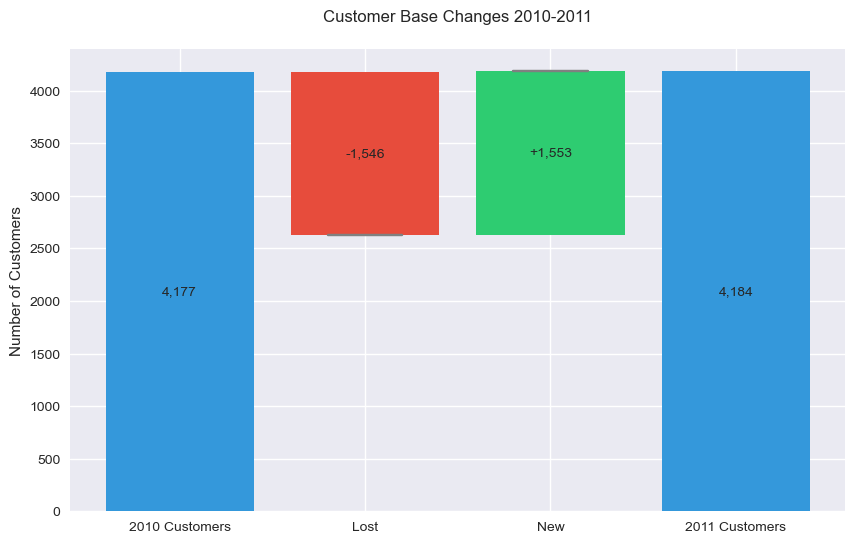

Number of retained customers: 2,631 (62.99%)
Number of lost customers: 1,546 (37.01%)
Number of new customers: 1,553 (37.12%)
Number of 2011 customers: 4,184


In [24]:
# Customer Waterfall Analysis 2010-2011
customers_2010 = df_clean[df_clean['year'] == 2010]['customer_id'].unique()
customers_2011 = df_clean[df_clean['year'] == 2011]['customer_id'].unique()

retained = len(np.intersect1d(customers_2010, customers_2011))
lost = len(customers_2010) - retained 
new = len(customers_2011) - retained

# Create waterfall data
labels = ['2010 Customers', 'Lost', 'New', '2011 Customers']
values = [len(customers_2010), -lost, new, len(customers_2011)]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#3498db']#2ecc71

# Create waterfall plot
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate cumulative positions
cumsum = np.cumsum(values)
start = cumsum - values

# Create bars
for i in range(len(values)):
    if i == 0:  # First total bar
        ax.bar(labels[i], values[i], color=colors[i])
    elif i == len(values)-1:  # Last total bar
        ax.bar(labels[i], values[i], bottom=0, color=colors[i])  # Start from 0
    else:  # Waterfall bars
        ax.bar(labels[i], values[i], bottom=start[i], color=colors[i])
        
# Add connecting lines between bars
for i in range(len(values)-1):
    if i != 0:  # Skip first connection
        ax.plot([i-0.2, i+0.2], [cumsum[i], cumsum[i]], color='gray', linestyle='-')

# Customize plot
plt.title('Customer Base Changes 2010-2011', pad=20)
plt.ylabel('Number of Customers')

# Add value labels on bars
for i in range(len(values)):
    if values[i] >= 0:
        label_pos = values[i]/2 if i == len(values)-1 else start[i] + values[i]/2
        label = f'+{values[i]:,.0f}' if i == 2 else f'{values[i]:,.0f}'
    else:
        label_pos = start[i] + values[i]/2
        label = f'{values[i]:,.0f}'
    
    ax.text(i, label_pos, label, ha='center', va='center')

plt.show()

# number of retained customers
print(f"Number of retained customers: {retained:,.0f} ({(retained/len(customers_2010))*100:.2f}%)")
# number of lost customers
print(f"Number of lost customers: {lost:,.0f} ({(lost/len(customers_2010))*100:.2f}%)")
# number of new customers
print(f"Number of new customers: {new:,.0f} ({(new/len(customers_2011))*100:.2f}%)")
# number of 2011 customers
print(f"Number of 2011 customers: {len(customers_2011):,.0f}")


1. **High Acquisition, But Offset by Losses**
The company added 1,553 new customers (37% of the 2011 base), indicating strong acquisition capability. However, this was almost completely offset by 1,546 customers lost from the 2010 base (37%), leaving net growth flat.

2. **Large Churn Rate**
Only 63% of 2010 customers were retained into 2011. With nearly 4 in 10 customers churning each year, acquisition alone cannot sustain growth without stronger retention.

Our stagnant customer base was not due to weak acquisition (new customer inflow was strong) but because losses were high. Growth stalled because the business is running in place. The key opportunity lies in strengthening retention strategies to protect acquired customers

<Figure size 1200x600 with 0 Axes>

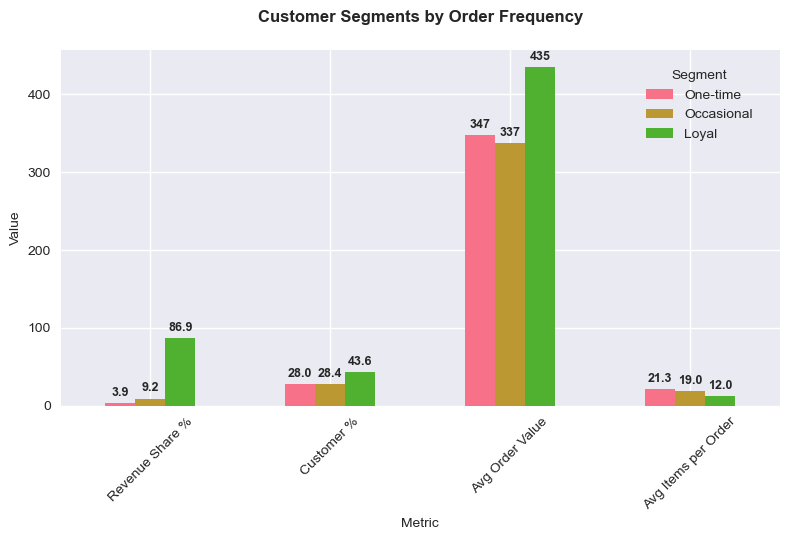


Order Frequency Segment Metrics:
--------------------------------------------------
                   Revenue Share %  Customer %  Avg Order Value  \
frequency_segment                                                 
One-time                       3.9        28.0           347.41   
Occasional                     9.2        28.4           337.24   
Loyal                         86.9        43.6           435.33   

                   Avg Items per Order  
frequency_segment                       
One-time                         21.29  
Occasional                       18.98  
Loyal                            12.02  


In [37]:
# limit to 2010 and 2011
df_filtered = df_clean[df_clean['order_date'].dt.year.isin([2010, 2011])]

# Create customer segments based on order frequency
customer_segments = df_filtered.groupby('customer_id').agg({
    'order_id': 'nunique',
    'total_amount': 'sum',
    'product_id': 'nunique'
}).reset_index()

# Order Frequency Segments
customer_segments['frequency_segment'] = pd.cut(
    customer_segments['order_id'],
    bins=[0, 1, 3, float('inf')],
    labels=['One-time', 'Occasional', 'Loyal'],
    right=True
)

# Calculate metrics for each segment type
def get_segment_metrics(segment_col):
        # Revenue share
    revenue_share = customer_segments.groupby(segment_col)['total_amount'].sum()
    revenue_share_pct = (revenue_share / revenue_share.sum() * 100).round(1)
    
    # Customer count
    customer_count = customer_segments[segment_col].value_counts()
    customer_pct = (customer_count / len(customer_segments) * 100).round(1)
    
    # Average order value
    avg_order_value = (revenue_share / customer_segments.groupby(segment_col)['order_id'].sum()).round(2)
    
    # Average unique items per order
    avg_items = customer_segments.groupby(segment_col)['product_id'].sum()/customer_segments.groupby(segment_col)['order_id'].sum()   
    
    metrics_df = pd.DataFrame({
        'Revenue Share %': revenue_share_pct,
        'Customer %': customer_pct,
        'Avg Order Value': avg_order_value,
        'Avg Items per Order': avg_items
    })
    
    return metrics_df

# Create single plot with wider dimensions
plt.figure(figsize=(12, 6))

# Plot Order Frequency Segments
freq_metrics = get_segment_metrics('frequency_segment')
freq_metrics_transposed = freq_metrics.transpose()
ax = freq_metrics_transposed.plot(kind='bar')
plt.title('Customer Segments by Order Frequency', pad=20, fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=10)
plt.xlabel('Metric', fontsize=10)
plt.xticks(rotation=45)
plt.legend(title='Segment', loc='upper right', bbox_to_anchor=(0.98, 0.98))

# Add data labels with formatting
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f'{x:,.1f}' if x < 100 else f'{x:,.0f}', 
                 padding=3, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nOrder Frequency Segment Metrics:")
print("-" * 50)
print(freq_metrics.round(2))


1. **Revenue is Highly Skewed Toward Loyal Customers**
Loyal buyers (44% of base) generate 87.7% of revenue, while one-time and occasional customers (56% of base) together contribute only 12.3%. This skew shows that growth depends on converting more of the base into loyal repeat customers, as acquisition without retention adds little revenue impact.

2. **Different Purchase Patterns Between Segments**
Loyal customers spend more per order (~$435) but buy fewer unique items per transaction (11.9 vs ~20 for one-time/occasional). This suggests loyal buyers focus on repeat, possibly bulk purchases of fewer SKUs, while first-time/occasional buyers experiment with more varied baskets.

The opportunity lies in reducing churn among new customers who already show strong purchase intent (showed by buying more varied product) but lack retention.

CUSTOMER ENGAGEMENT DEPTH ANALYSIS
--------------------------------------------------


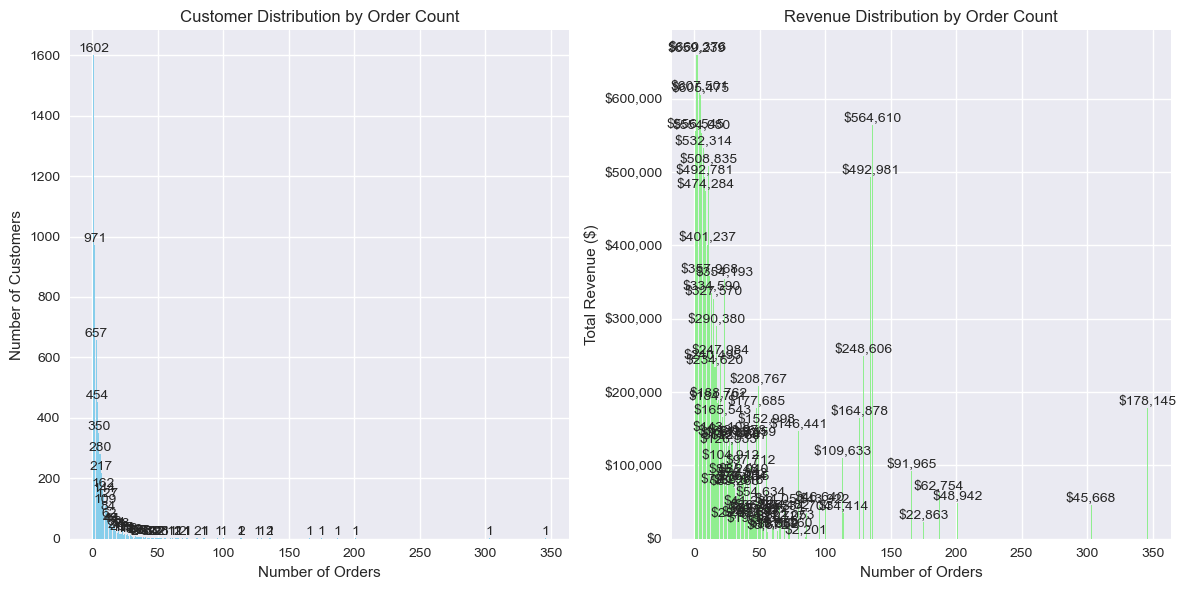


Engagement Summary:
Single Order Customers: 1602 (28.0%)
Average Orders per Customer: 5.9


In [40]:
# Analyze engagement depth through orders and revenue
print("CUSTOMER ENGAGEMENT DEPTH ANALYSIS")
print("-" * 50)

# limit to 2010 and 2011
df_filtered = df_clean[df_clean['order_date'].dt.year.isin([2010, 2011])]

# Calculate orders per customer
orders_per_customer = df_filtered.groupby('customer_id').agg({
    'order_id': 'nunique',
    'total_amount': 'sum'
}).reset_index()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Left plot - Customer Distribution
customer_dist = orders_per_customer['order_id'].value_counts().sort_index()
ax1.bar(customer_dist.index, customer_dist.values, color='skyblue')
ax1.set_xlabel('Number of Orders')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Customer Distribution by Order Count')

# Add value labels on bars
for i, v in enumerate(customer_dist.values):
    ax1.text(customer_dist.index[i], v, str(v), ha='center', va='bottom')

# Right plot - Revenue Distribution
revenue_by_orders = orders_per_customer.groupby('order_id')['total_amount'].sum().sort_index()
ax2.bar(revenue_by_orders.index, revenue_by_orders.values, color='lightgreen')
ax2.set_xlabel('Number of Orders')
ax2.set_ylabel('Total Revenue ($)')
ax2.set_title('Revenue Distribution by Order Count')

# Format y-axis labels to show thousands with K
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Add value labels on bars
for i, v in enumerate(revenue_by_orders.values):
    ax2.text(revenue_by_orders.index[i], v, f'${v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nEngagement Summary:")
print(f"Single Order Customers: {customer_dist.get(1, 0)} ({customer_dist.get(1, 0)/len(orders_per_customer)*100:.1f}%)")
print(f"Average Orders per Customer: {orders_per_customer['order_id'].mean():.1f}")


CUSTOMER COHORT ANALYSIS
--------------------------------------------------


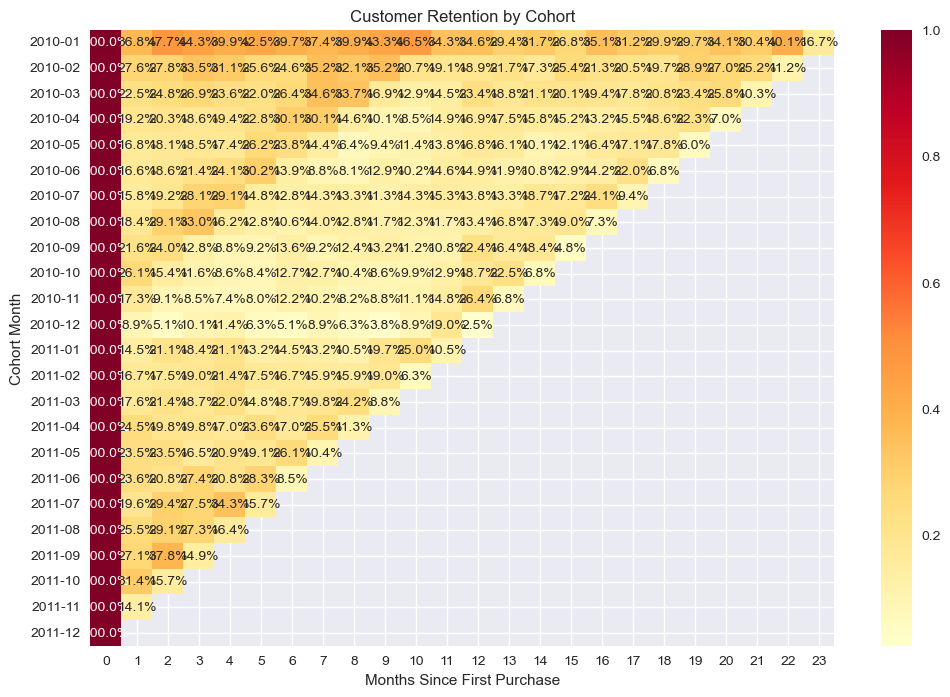

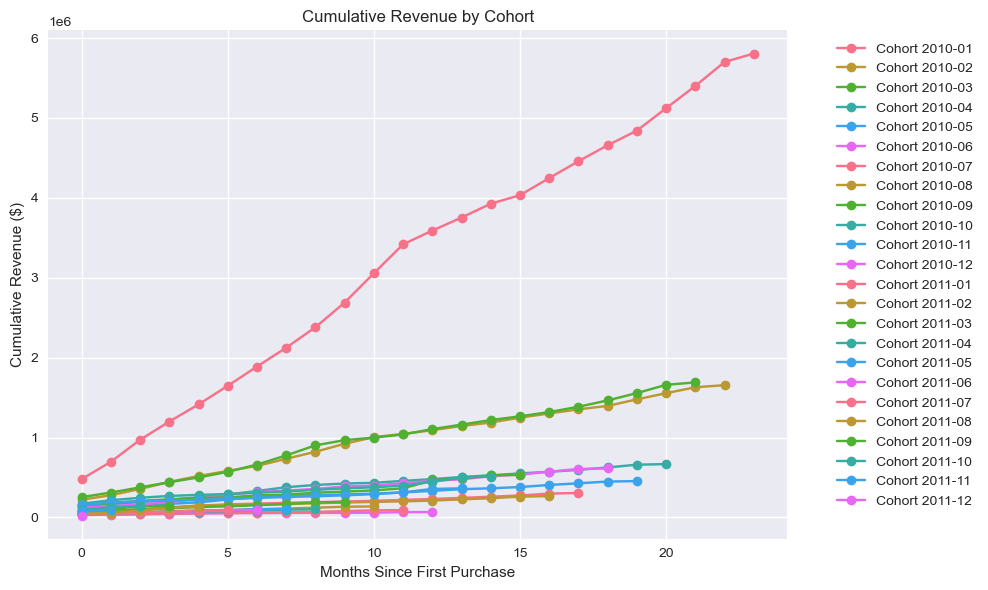

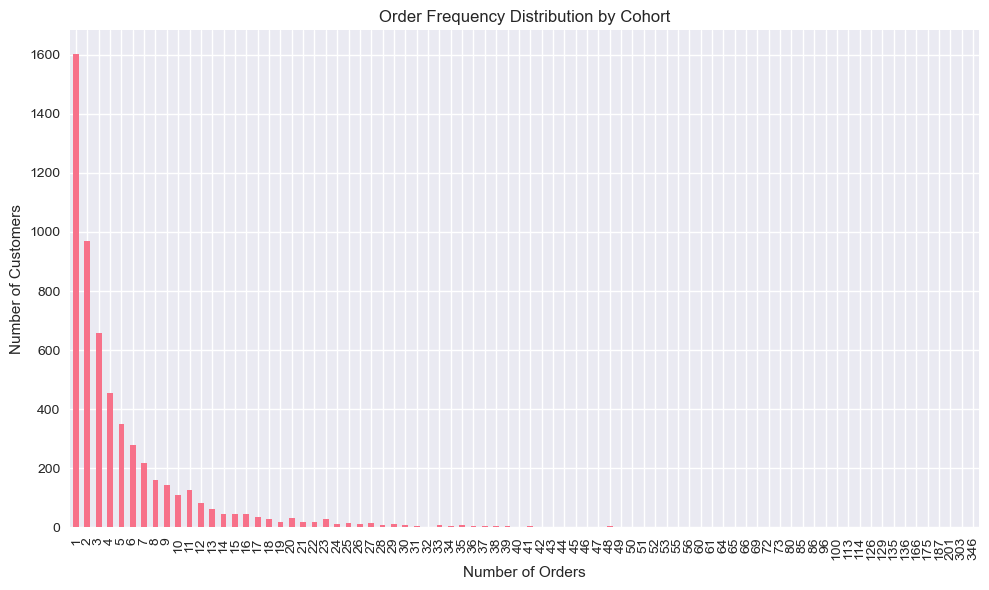


Cohort Analysis Summary:
Number of Cohorts: 24
Average 3-month retention rate: 21.7%
Average 6-month retention rate: 18.2%


In [51]:
# Cohort Analysis
print("CUSTOMER COHORT ANALYSIS")
print("-" * 50)

# limit to 2010 to november 2011
df_filtered = df_clean[df_clean['order_date'].dt.year.isin([2010, 2011])]

# Create cohort data
df_cohort = df_filtered.copy()
df_cohort['cohort_month'] = df_cohort['order_date'].dt.to_period('M')
df_cohort['order_month'] = df_cohort['order_date'].dt.to_period('M') 

# Get the first purchase month for each customer
customer_first_purchase = df_cohort.groupby('customer_id')['cohort_month'].min()
df_cohort['cohort_month'] = df_cohort['customer_id'].map(customer_first_purchase)

# Calculate months since first purchase
def get_month_diff(x, y):
    return (x.year - y.year) * 12 + (x.month - y.month)

df_cohort['months_since_first'] = df_cohort.apply(
    lambda x: get_month_diff(x['order_month'], x['cohort_month']), axis=1)

# Retention Analysis
cohort_data = df_cohort.groupby(['cohort_month', 'months_since_first'])['customer_id'].nunique()
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='cohort_month', 
                                 columns='months_since_first',
                                 values='customer_id')

# Calculate retention rates
cohort_sizes = cohort_counts[0]
retention_rates = cohort_counts.divide(cohort_sizes, axis=0)

# Plot retention heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention_rates.round(3), 
            annot=True, 
            fmt='.1%',
            cmap='YlOrRd')
plt.title('Customer Retention by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.show()

# Revenue Cohorts
revenue_cohort = df_cohort.groupby(['cohort_month', 'months_since_first'])['total_amount'].sum()
revenue_cohort = revenue_cohort.reset_index()
revenue_matrix = revenue_cohort.pivot(index='cohort_month',
                                    columns='months_since_first',
                                    values='total_amount')

# Calculate cumulative revenue
cumulative_revenue = revenue_matrix.cumsum(axis=1)

# Plot cumulative revenue
plt.figure(figsize=(10, 6))
for idx, row in cumulative_revenue.iterrows():
    plt.plot(row.index, row.values, marker='o', label=f'Cohort {idx}')
plt.title('Cumulative Revenue by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cumulative Revenue ($)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Order Frequency Progression
frequency_cohorts = df_cohort.groupby(['customer_id', 'cohort_month'])['order_id'].nunique()
frequency_dist = frequency_cohorts.value_counts().sort_index()

plt.figure(figsize=(10, 6))
frequency_dist.plot(kind='bar')
plt.title('Order Frequency Distribution by Cohort')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


print("\nCohort Analysis Summary:")
print(f"Number of Cohorts: {len(cohort_counts)}")
print(f"Average 3-month retention rate: {retention_rates[3].mean():.1%}")
print(f"Average 6-month retention rate: {retention_rates[6].mean():.1%}")


In [ ]:
# New vs Repeat Customers Revenue Share
print("NEW VS REPEAT CUSTOMERS REVENUE SHARE")
print("-" * 50)

# Identify first purchase year per customer
first_purchase_year = df_clean.groupby('customer_id')['order_date'].min().dt.year
customer_year = df_clean[['customer_id', 'order_date']].copy()
customer_year['first_year'] = customer_year['customer_id'].map(first_purchase_year)
customer_year['year'] = customer_year['order_date'].dt.year

# Tag orders as new or repeat
customer_year['Type'] = np.where(customer_year['year'] == customer_year['first_year'], 'New', 'Repeat')
df_clean = df_clean.merge(customer_year[['customer_id', 'order_date', 'Type']], on=['customer_id', 'order_date'], how='left')

# Revenue share by type and year
revenue_share = df_clean.groupby(['year', 'Type'])['total_amount'].sum().unstack().fillna(0)
revenue_share['Total'] = revenue_share.sum(axis=1)
revenue_share['New_Share'] = revenue_share['New'] / revenue_share['Total']
revenue_share['Repeat_Share'] = revenue_share['Repeat'] / revenue_share['Total']

display(revenue_share[['New', 'Repeat', 'New_Share', 'Repeat_Share']].round(2))

NEW VS REPEAT CUSTOMERS REVENUE SHARE
--------------------------------------------------


Type,New,Repeat,New_Share,Repeat_Share
year,,,,
2009,1.666391e+07,0.000000e+00,1.00,0.00
2010,1.248573e+08,1.108621e+08,0.53,0.47
2011,6.502766e+07,1.738121e+08,0.27,0.73


ORDER FREQUENCY DISTRIBUTION
--------------------------------------------------


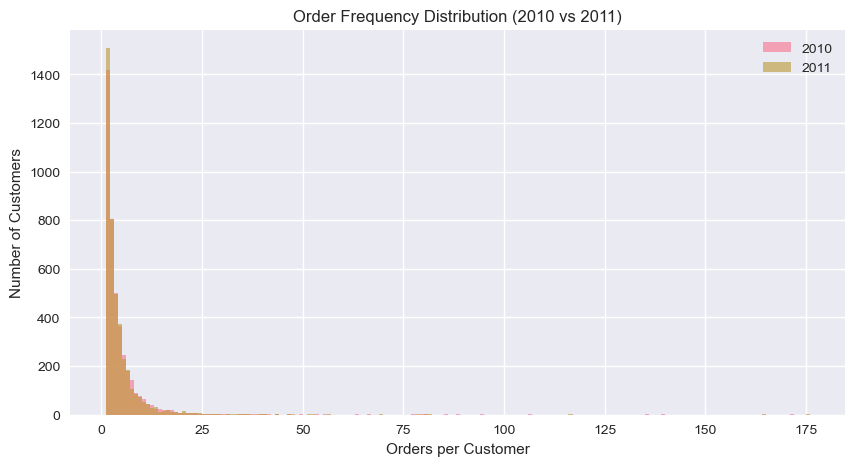

In [ ]:
# Order Frequency Distribution
print("ORDER FREQUENCY DISTRIBUTION")
print("-" * 50)

# Orders per customer by year
orders_per_customer = df_clean.groupby(['customer_id', 'year'])['order_id'].nunique().reset_index()

plt.figure(figsize=(10,5))
for yr in [2010, 2011]:
    data = orders_per_customer[orders_per_customer['year'] == yr]['order_id']
    plt.hist(data, bins=range(1, data.max()+2), alpha=0.6, label=str(yr))
plt.xlabel('Orders per Customer')
plt.ylabel('Number of Customers')
plt.title('Order Frequency Distribution (2010 vs 2011)')
plt.legend()
plt.show()

In [ ]:
# Customer Retention Waterfall: 2010 vs 2011
# This plot shows how many customers are retained, lost, or new in 2011

# Get unique customers for each year
customers_2010 = set(df_clean[df_clean['year'] == 2010]['customer_id'])
customers_2011 = set(df_clean[df_clean['year'] == 2011]['customer_id'])

# Calculate categories
retained = len(customers_2010 & customers_2011)  # present in both years
lost = len(customers_2010 - customers_2011)      # present in 2010 only
new = len(customers_2011 - customers_2010)       # present in 2011 only

# Prepare data for plotting
labels = ['2010 Customers', 'Lost in 2011', 'Retained', 'New in 2011', '2011 Customers']
values = [len(customers_2010), -lost, retained, new, len(customers_2011)]

# Waterfall-style bar plot
fig, ax = plt.subplots(figsize=(8,5))
bar_positions = [0, 1, 2, 3, 4]
bar_colors = ['gray', 'red', 'green', 'blue', 'gray']

# Plot bars
ax.bar(bar_positions[0], values[0], color=bar_colors[0], label='2010 Customers')
ax.bar(bar_positions[1], values[1], bottom=values[0], color=bar_colors[1], label='Lost')
ax.bar(bar_positions[2], values[2], bottom=values[0]+values[1], color=bar_colors[2], label='Retained')
ax.bar(bar_positions[3], values[3], bottom=values[0]+values[1]+values[2], color=bar_colors[3], label='New')
ax.bar(bar_positions[4], values[4], color=bar_colors[4], label='2011 Customers')

# Set labels and title
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels, rotation=20)
ax.set_ylabel('Number of Customers')
ax.set_title('Customer Retention Waterfall: 2010 vs 2011')

# Annotate values
for i, v in enumerate(values):
    ax.text(bar_positions[i], v if v > 0 else 0, f'{abs(v):,}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()


REVENUE CONCENTRATION (PARETO)
--------------------------------------------------


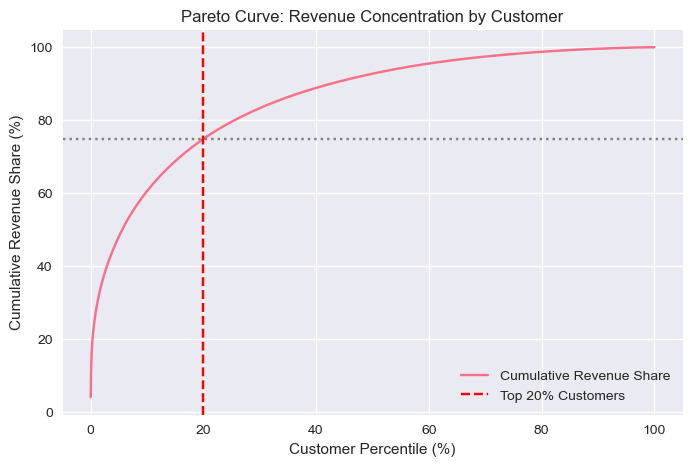

In [ ]:
# Revenue Concentration (Pareto)
print("REVENUE CONCENTRATION (PARETO)")
print("-" * 50)

# Sort customers by total revenue
customer_rev = customer_metrics['Monetary'].sort_values(ascending=False).reset_index(drop=True)
cum_rev = customer_rev.cumsum() / customer_rev.sum()
percentile = np.arange(1, len(customer_rev)+1) / len(customer_rev)

plt.figure(figsize=(8,5))
plt.plot(percentile*100, cum_rev*100, label='Cumulative Revenue Share')
plt.axvline(20, color='red', linestyle='--', label='Top 20% Customers')
plt.axhline(cum_rev.iloc[int(0.2*len(customer_rev))]*100, color='gray', linestyle=':')
plt.xlabel('Customer Percentile (%)')
plt.ylabel('Cumulative Revenue Share (%)')
plt.title('Pareto Curve: Revenue Concentration by Customer')
plt.legend()
plt.show()

**Customer Growth & Engagement: Key Findings**

- The customer base is dominated by one-time and repeat buyers, with loyal customers forming a small but valuable segment.
- Revenue share from new customers has not grown, and repeat purchase rates have softened, especially in 2011.
- The distribution of orders per customer is skewed, with most customers making only a few purchases per year.
- The Pareto analysis confirms that a small fraction of customers (top 20%) contribute a disproportionate share of revenue.

**Insight Direction:**
Growth slowed because the customer base barely expanded and repeat purchases weakened. The key opportunity lies in reactivating dormant customers and acquiring new ones to broaden revenue sources. Targeted campaigns and loyalty programs can help lift engagement and transaction frequency.

## 5. Product Mix & Assortment Health

A healthy product assortment is essential for sustaining revenue growth. This section examines product variety trends, top product contributions, long-tail performance, and identifies key decliners and gainers to inform assortment strategy.

PRODUCT VARIETY TREND
--------------------------------------------------


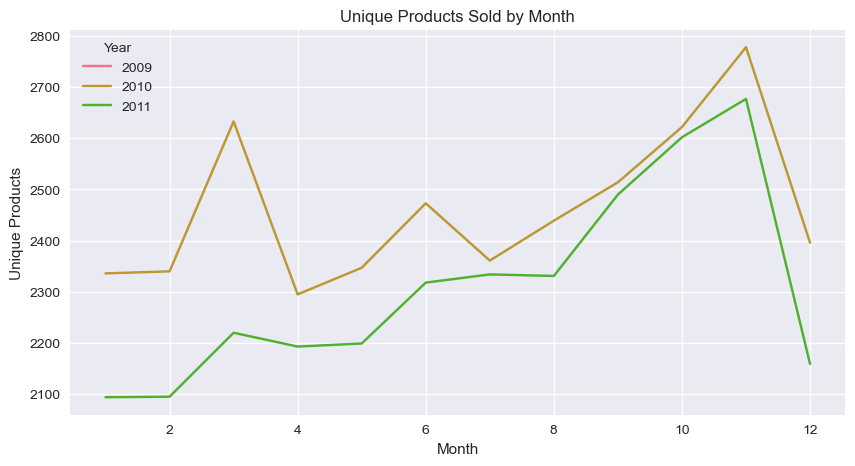

In [ ]:
# Product Variety Trend
print("PRODUCT VARIETY TREND")
print("-" * 50)

# Unique products by year and month
products_by_year = df_clean.groupby('year')['product_id'].nunique()
products_by_month = df_clean.groupby(['year', 'month'])['product_id'].nunique().unstack(0)

plt.figure(figsize=(10,5))
products_by_month.plot(ax=plt.gca())
plt.title('Unique Products Sold by Month')
plt.xlabel('Month')
plt.ylabel('Unique Products')
plt.legend(title='Year')
plt.show()

In [ ]:
# Top Products Contribution
print("TOP PRODUCTS CONTRIBUTION")
print("-" * 50)

top_n = [10, 50]
top_contrib = {}
for year in [2010, 2011]:
    df_year = df_clean[df_clean['year'] == year]
    prod_rev = df_year.groupby('product_id')['total_amount'].sum().sort_values(ascending=False)
    total_rev = prod_rev.sum()
    for n in top_n:
        share = prod_rev.head(n).sum() / total_rev
        top_contrib[(year, n)] = share

top_contrib_df = pd.DataFrame(top_contrib, index=['Revenue Share']).T
print("Revenue share of top products:")
display(top_contrib_df)

TOP PRODUCTS CONTRIBUTION
--------------------------------------------------
Revenue share of top products:
Revenue share of top products:


Revenue Share
2010 10       0.050792
     50       0.151806
2011 10       0.052608
     50       0.155499

In [ ]:
# Long-tail Analysis
print("LONG-TAIL ANALYSIS")
print("-" * 50)

long_tail_share = {}
for year in [2010, 2011]:
    df_year = df_clean[df_clean['year'] == year]
    prod_rev = df_year.groupby('product_id')['total_amount'].sum()
    total_rev = prod_rev.sum()
    long_tail = prod_rev[prod_rev < 0.01 * total_rev].sum() / total_rev
    long_tail_share[year] = long_tail
print("Share of revenue from long-tail products (<1% each):")
print(long_tail_share)

LONG-TAIL ANALYSIS
--------------------------------------------------
Share of revenue from long-tail products (<1% each):
{2010: 0.9899093837368933, 2011: 1.0}
Share of revenue from long-tail products (<1% each):
{2010: 0.9899093837368933, 2011: 1.0}


In [ ]:
# Decliners vs Gainers
print("DECLINERS VS GAINERS")
print("-" * 50)

# Product revenue by year
prod_rev_2010 = df_clean[df_clean['year'] == 2010].groupby('product_id')['total_amount'].sum()
prod_rev_2011 = df_clean[df_clean['year'] == 2011].groupby('product_id')['total_amount'].sum()

prod_change = pd.DataFrame({'2010': prod_rev_2010, '2011': prod_rev_2011}).fillna(0)
prod_change['Change'] = prod_change['2011'] - prod_change['2010']

# Top decliners and gainers
top_decliners = prod_change.sort_values('Change').head(10)
top_gainers = prod_change.sort_values('Change', ascending=False).head(10)

print("Top Decliners:")
display(top_decliners)
print("Top Gainers:")
display(top_gainers)

DECLINERS VS GAINERS
--------------------------------------------------
Top Decliners:
Top Decliners:


,2010,2011,Change
product_id,,,
85123A,2378553.97,1266138.00,-1112415.97
22837,534362.30,16400.55,-517961.75
48138,917667.04,449512.35,-468154.69
21843,782155.82,314499.75,-467656.07
21623,622707.82,191196.22,-431511.60
37503,425850.40,0.00,-425850.40
20685,994407.73,589722.15,-404685.58
85232B,400347.90,0.00,-400347.90
22444,390675.92,28615.00,-362060.92


Top Gainers:


,2010,2011,Change
product_id,,,
23084,0.0,1426478.58,1426478.58
23298,0.0,1032307.85,1032307.85
23203,0.0,860469.48,860469.48
23284,0.0,816445.62,816445.62
22960,129432.0,940831.80,811399.80
47566,766954.4,1564005.06,797050.66
22720,15675.9,805818.95,790143.05
23245,0.0,728174.14,728174.14
23209,0.0,657894.13,657894.13


**Product Mix & Assortment Health: Key Findings**

- The number of unique products sold declined, reducing assortment breadth and limiting cross-sell opportunities.
- Revenue is increasingly concentrated among top products, while the long-tail share has shrunk.
- Several previously strong products lost momentum, while a few new winners emerged.

**Insight Direction:**
Revenue pressure links to product contraction: assortment shrank, and some high-performing products lost momentum. Reinforcing core performers and refreshing weak categories can re-expand opportunities for spend.

## 6. Seasonality & Demand Alignment

Understanding sales seasonality is essential for aligning inventory and marketing with demand. This section analyzes monthly sales trends, year-on-year seasonality, and applies rolling averages to reveal underlying patterns.

MONTHLY SALES TREND
--------------------------------------------------


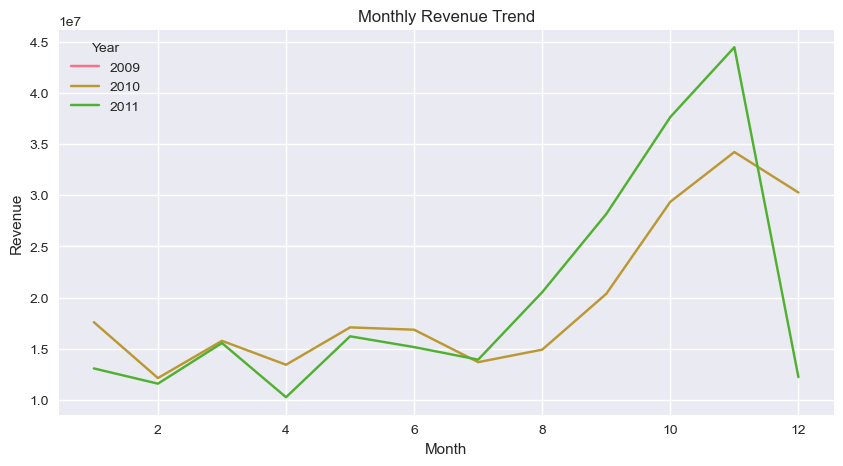

In [ ]:
# Monthly Sales Trend
print("MONTHLY SALES TREND")
print("-" * 50)

monthly_sales = df_clean.groupby(['year', 'month'])['total_amount'].sum().unstack(0)
plt.figure(figsize=(10,5))
monthly_sales.plot(ax=plt.gca())
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend(title='Year')
plt.show()

YEAR-ON-YEAR SEASONALITY
--------------------------------------------------


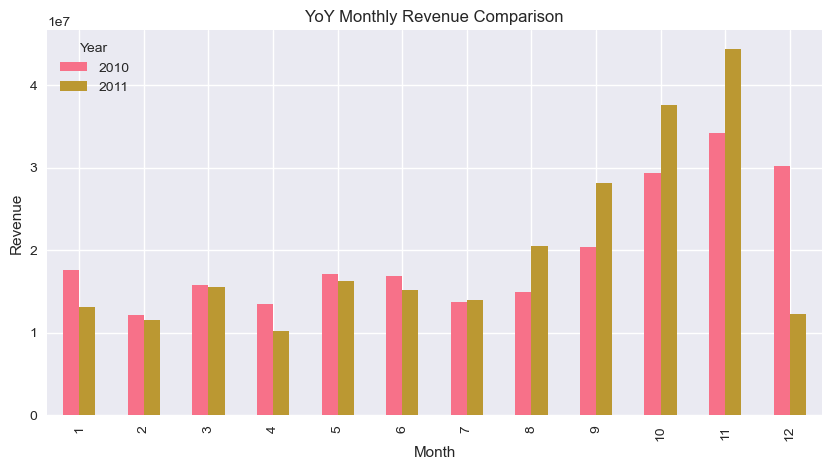

In [ ]:
# Year-on-Year Seasonality
print("YEAR-ON-YEAR SEASONALITY")
print("-" * 50)

yoy_monthly = monthly_sales.copy()
yoy_monthly = yoy_monthly.loc[:, [2010, 2011]]
yoy_monthly.plot(kind='bar', figsize=(10,5))
plt.title('YoY Monthly Revenue Comparison')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend(title='Year')
plt.show()

ROLLING AVERAGE (3-MONTH)
--------------------------------------------------


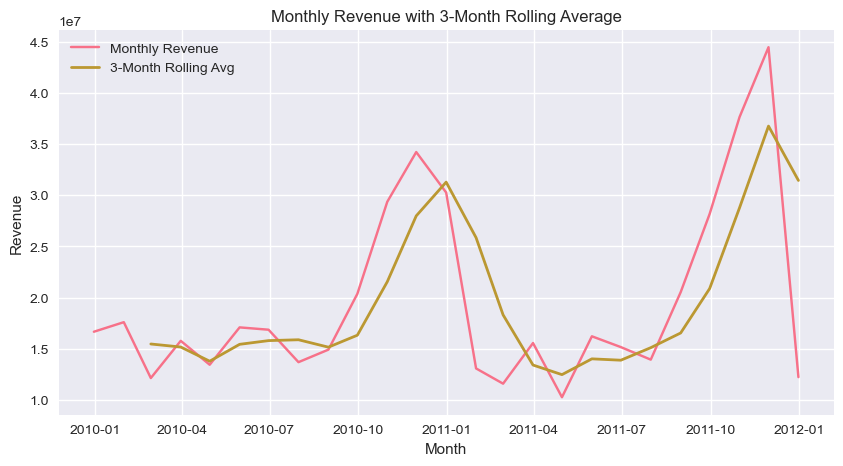

In [ ]:
# Rolling Average (3-month)
print("ROLLING AVERAGE (3-MONTH)")
print("-" * 50)

monthly_sales_flat = df_clean.groupby('order_date')['total_amount'].sum().resample('M').sum()
rolling_avg = monthly_sales_flat.rolling(3).mean()
plt.figure(figsize=(10,5))
plt.plot(monthly_sales_flat.index, monthly_sales_flat.values, label='Monthly Revenue')
plt.plot(rolling_avg.index, rolling_avg.values, label='3-Month Rolling Avg', linewidth=2)
plt.title('Monthly Revenue with 3-Month Rolling Average')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.show()

**Seasonality & Demand Alignment: Key Findings**

- Sales show clear seasonal peaks and troughs, with some months underperforming year-on-year.
- The rolling average highlights underlying demand patterns, smoothing out volatility.

**Insight Direction:**
Sales volatility reflects seasonal swings, with missed potential in peak months. Recognizing these patterns enables aligning stock and campaigns with expected demand, capturing upside while avoiding overstock in troughs.

## 7. Country Context (Optional)

While the country distribution is heavily skewed toward the UK, it is useful to review revenue share by country for completeness.

REVENUE SHARE BY COUNTRY (TOP 10)
--------------------------------------------------


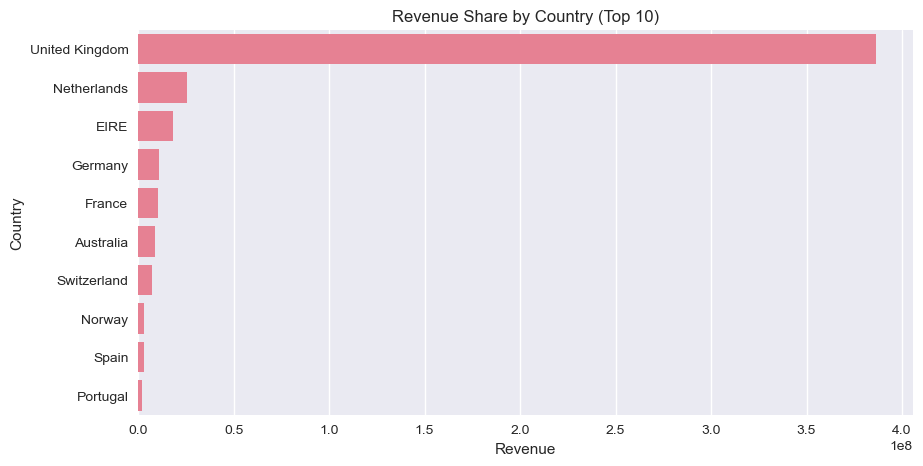

In [ ]:
# Revenue Share by Country (Top 10)
print("REVENUE SHARE BY COUNTRY (TOP 10)")
print("-" * 50)

country_rev = df_clean.groupby('country')['total_amount'].sum().sort_values(ascending=False)
top_countries = country_rev.head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Revenue Share by Country (Top 10)')
plt.xlabel('Revenue')
plt.ylabel('Country')
plt.show()

**Country Context: Key Findings**

- The UK overwhelmingly dominates revenue, with other countries contributing marginally.
- While international expansion is limited, the UK market remains the primary focus for growth and retention strategies.

---

This structured analysis provides a clear roadmap for management to address stalled growth, optimize product assortment, and align operations with demand patterns. The next steps involve translating these insights into targeted actions for sales, marketing, and inventory planning.